# 1. Data Processing and Visualization

## 1.1. Importing Libraries
The first step is to import all the necessary libraries and functions. We will be using PyTorch in this tutorial for training the model.

In [1]:
# Imports necessary for training the model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

# Few other important libraries
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(0)

## 1.2. Downloading and Augmenting Data
We will be using the **CIFAR10** dataset available in PyTorch datasets and we will augment it before using it for the model.

Few points about **Data Augmentation:**

1. Data Augmentation helps the model to perform well even if the images are slightly modified as compared to the original dataset. 

2. We will be resizing the original dataset from 32X32 to 227X227 as the model we use requires the input to be of this size. 
 
3. We also introduce random horizontal flips, random cropping and finally normalize the image to improve the performance of the model.

In [2]:
# Transform for Data Augmentation
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(227, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.244, 0.262])  # Normalize
])

Now, we download the training and test dataset using PyTorch. The images are 8-bit images i.e. intensity values are between [0, 255] and their size is 32X32X3.

In [3]:
train_data = dsets.CIFAR10(root = './data', train = True, download = True, transform = transform)
test_data = dsets.CIFAR10(root = './data', train = False, download = True, transform = transform)
print(train_data.data.dtype)
print(train_data.data.shape)

100%|██████████| 170498071/170498071 [00:03<00:00, 49531356.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
uint8
(50000, 32, 32, 3)


For training any model, we need three datasets namely training, test and validation dataset. Training dataset is used for training, validation set is used for selecting best hyperparameters and test dataset is used for testing the model's performance on unseen data.

In [4]:
# Create a validation set from the training data
train_size_fraction = 0.8
train_size = int(train_size_fraction*len(train_data))  # 80% for training
val_size = len(train_data) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [5]:
def inverse_normalize(image, mean, std):
    '''
    Function:- Used to invert the normalization for an image to retrieve the original image
    
    Inputs:-
    image: Normalized Image
    mean: Mean of RGB Channels
    std: Standard Deviation of RGB Channels
    
    return: image with pixels between 0 and 1
    '''
    for i in range(image.shape[0]):
        image[i] = image[i] * std[i] + mean[i]
    return image.clamp(0, 1)  # Ensure values are within [0, 1]

In [6]:
# This label map is used for mapping labels with class names
label_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

In [7]:
def show_image(data, idx, label_map):
    ''''
    Function:- Displays a single image
    
    Inputs:-
    data: dataset
    idx: index of image in the dataset
    label_map: mapping of labels to objects
    
    return: plots the original and transformed images side by side
    '''
    # Get the original image (32x32)
    original_image = data.data[idx]
    original_label = data.targets[idx]
    
    # Get the transformed image (227x227)
    transformed_image, transformed_label = data[idx]
    transformed_image = inverse_normalize(transformed_image, mean=[0.491, 0.482, 0.447], std=[0.247, 0.244, 0.262])
    
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot original image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original: {label_map[original_label]}')
    axes[0].axis('off')  # Hide axes
    
    # Plot transformed image
    axes[1].imshow(transformed_image.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    axes[1].set_title(f'Transformed: {label_map[transformed_label]}')
    axes[1].axis('off')  # Hide axes
    
    plt.show()

We will plot the 6th image as an example to observe the original and transformed image

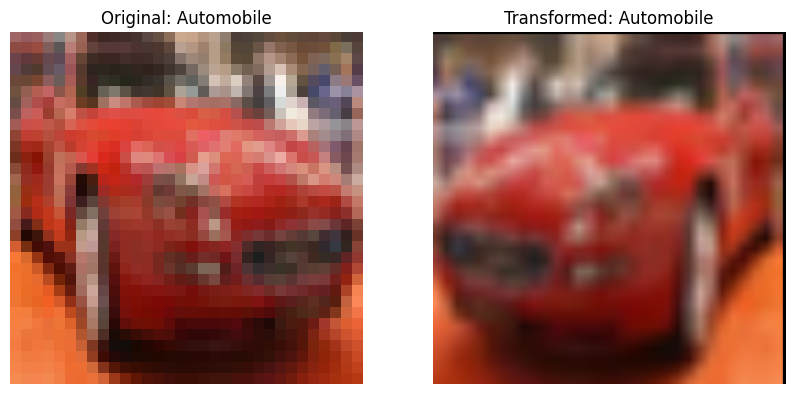

In [8]:
idx = 5
show_image(train_data, idx, label_map)

We need to create dataloaders for training and testing the model. This are used for faster processing in batches.

In [9]:
batch_size = 128 # Batch Size of the images

# Creating dataloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

# Printing the no. of samples in each dataset
print("No. of samples in training dataset:", len(train_loader.dataset))
print("No. of samples in validation dataset:", len(val_loader.dataset))
print("No. of samples in test dataset:", len(test_loader.dataset))

No. of samples in training dataset: 40000
No. of samples in validation dataset: 10000
No. of samples in test dataset: 10000


We will visualize the first batch of training dataset which will be used for training the model.

torch.Size([128, 3, 227, 227])


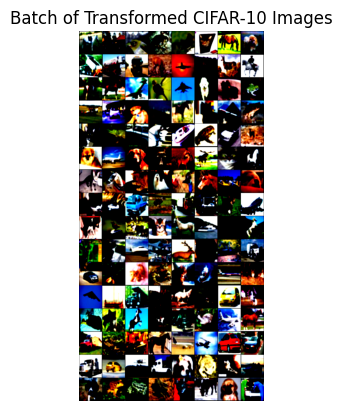

In [10]:
# Getting the first batch in training dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# Plotting the first batch
plt.imshow(utils.make_grid(images).permute(1, 2, 0))
plt.title('Batch of Transformed CIFAR-10 Images')
plt.axis('off')
plt.show()

# 2. Training the Model 

## 2.1. Live Training

The model we are using here is AlexNet. This was the first architecture that used GPU to boost the training performance. AlexNet consists of **5 convolution layers**, **3 max-pooling layers**, **2 Normalized layers**, **2 fully connected layers** and **1 SoftMax layer**. Each convolution layer consists of a convolution filter and a non-linear activation function called “ReLU”. The pooling layers are used to perform the max-pooling function and the input size is fixed due to the presence of fully connected layers. The input size is mentioned at most of the places as 224x224x3 but due to some padding which happens it works out to be 227x227x3. Above all this AlexNet has over 60 million parameters.

The architecture of this model is given below:-

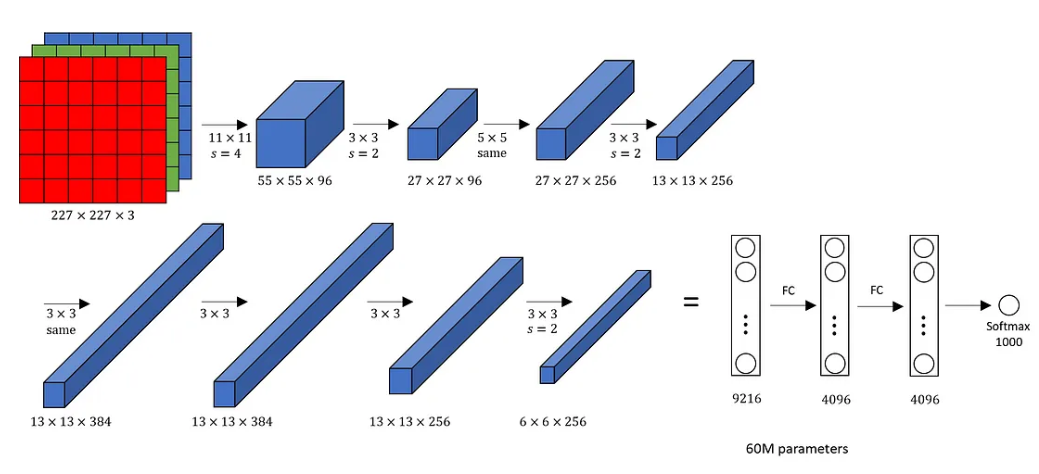

The tabulated architecture is as follows:-

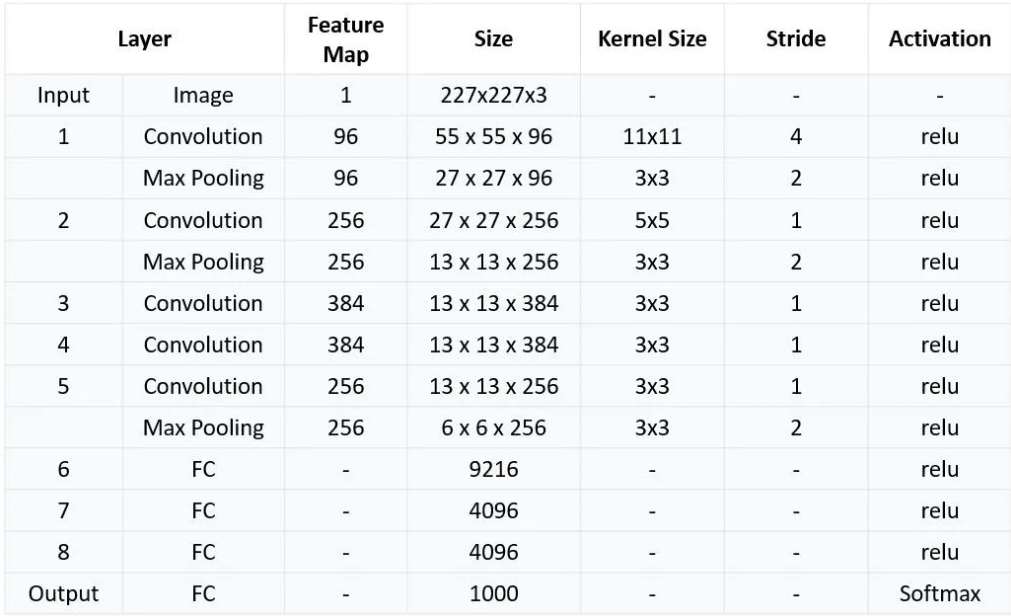



Now, we create a class to build the Alexnet model from scratch. The only modification in comparison to the original architecture is no. of classes in the output layer.

We need to complete the below model before proceeding ahead.

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),  # Input: (227, 227, 3)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Output: (27, 27, 96)

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Output: (13, 13, 256)

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),                  # Output: (13, 13, 384)
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),                  # Output: (13, 13, 384)

            # Add a convolutional layer with 256 filters of size 3X3 with stride 1 and same padding
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # Output: (6, 6, 256)
            
            nn.Flatten(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(4096, num_classes)  # Output: (num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [12]:
# We need to ensure whether the GPU from Kaggle is available or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model will be trained using {device}.")

Model will be trained using cuda.


We will be needing the helper functions given below for calculating the no. of correct predictions and the time spent between two timestamps.

In [13]:
def calculate_correct_predictions(out, labels):
    '''
    Function:- Calculates the no. of correct predictions
    
    Inputs:-
    out: Output from the model
    labels: True labels
    
    Output: Count of correct predictions
    '''
    _, pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

def epoch_time(start_time, end_time):
    '''
    Function:- Calculates the time between two timestamps
    
    Inputs:-
    start_time: Timestamp at the start
    end_time: Timestamp at the end
    
    returns: Elapsed minutes and seconds
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The function *train_model* trains a given model using training dataset and saves the model based on the model's performance on validation dataset

In [14]:
def create_model(model_name='AlexNet', device='cuda'):
    if model_name == 'AlexNet':
        model = AlexNet()
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False  # Freeze all layers
        model.classifier[6] = torch.nn.Linear(4096, 10)  # Modify for CIFAR-10
    elif model_name == 'ResNet18':
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False  # Freeze all layers
        model.fc = torch.nn.Linear(512, 10)  # Modify for CIFAR-10
    else:
        raise ValueError("Model not supported. Choose from 'VGG16', 'AlexNet', or 'ResNet18'.")
    
    return model.to(device)

def store_model(model, model_name):
    torch.save(model.state_dict(), f'finetuned_{model_name.lower()}.pth')
    print(f"Model saved as 'finetuned_{model_name.lower()}.pth'.")
    

def load_stored_model(model_name, filepath, device='cuda'):
    '''
    Function: Loads the stored model (trained in the past)
    
    Inputs:-
    model_name: Name of model
    filepath: Path of the stored model
    device: Device on which the model has to be used
    
    Returns: 
    Model loaded with weights and ready for testing
    '''
    model = create_model(model_name)
    model.load_state_dict(torch.load(filepath))
    return model

In [15]:
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    '''
    Function:- Trains the given model with given data and hyperparameters
    
    Inputs:-
    model: PyTorch Model
    train_loader: Dataloader of Training Data
    val_loader: Dataloader of Validation Data
    criterion: Loss Function
    optimizer: Optimizer for training
    num_epochs: No. of epochs
    device: Device for training
    save_path: Path for saving the best model
    
    Outputs-
    model: Trained model
    Training cost, Training Accuracy and Validation Accuracy at each Epoch
    '''
    # Variables useful for plotting later
    cost_train_list = []
    accuracy_train_list = []
    accuracy_val_list = []
    
    # Best accuracy to determine whether model has to be stored or not
    best_accuracy = 0
    start_time = time.time() # Timestamp for start of the training
    save_path = f'best_model_{model_name.lower()}.pth'
    print(f"Model will be saved as '{save_path}'")
    
    # Iterating through each epoch
    for epoch in range(1, num_epochs+1):
        print(f"------------------------ Epoch No. {epoch} ------------------------")
        start_epoch = time.time() # Timestamp for start of current epoch
        running_loss = 0
        correct_train, correct_val = 0, 0
        
        # tqdm library is used for displaying the progress bar
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', unit='batch') as tepoch:
            # Iterating through each batch
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                # Output is obtained
                outputs = model(images)
                
                # Loss is calculated and propagated backwards
                loss = criterion(outputs, labels)
                loss.backward()
                running_loss += loss.item()
                
                # Gradients are updated
                optimizer.step()
                
                # No. of correct predictions are calculated
                correct_train += calculate_correct_predictions(outputs, labels)

                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=(correct_train / ((tepoch.n + 1) * train_loader.batch_size)) * 100)  # Update progress bar with current loss
                tepoch.update()  # Increment the progress bar

            # Training accuracy is calculated and stored
            cost_train_list.append(running_loss)
            acc_train = (correct_train/len(train_loader.dataset))*100
            accuracy_train_list.append(acc_train)
            print(f"\nEpoch {epoch}: Accuracy on Train Set = {acc_train:.2f} %, Training Cost = {running_loss:.2f}")

            # Performance on validation dataset is checked
            print(f"Validation begins for Epoch {epoch}...")
            
            # 'torch.no_grad()' is used to disable gradient calculation during the inference or testing phase
            with torch.no_grad():
                # Iterating through each batch
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    
                    # Output is obtained
                    z = model(x_val)
                    # Correct no. of predictions is calculated
                    correct_val += calculate_correct_predictions(z, y_val)

            # Validation dataset's accuracy is calculated and stored
            acc_val = (correct_val/len(val_loader.dataset))*100
            accuracy_val_list.append(acc_val)
            
            # If current epoch's validation set accuracy is greater than best accuracy, current model is saved.
            if acc_val > best_accuracy:
                best_accuracy = acc_val
                torch.save(model.state_dict(), save_path)
                print(f"Model saved with accuracy: {best_accuracy:.2f} %")
            
            print(f"Epoch {epoch}: Accuracy on Validation Set = {acc_val:.2f} %")
            end_epoch = time.time()
            epoch_mins, epoch_secs = epoch_time(start_epoch, end_epoch)
            print(f"Runtime for Epoch {epoch}: {epoch_mins} minutes and {epoch_secs} seconds.\n")
            torch.cuda.empty_cache()

    end_time = time.time() # Timestamp for the end of the training phase
    total_mins, total_secs = epoch_time(start_time, end_time)
    print(f"\nTotal Runtime: {total_mins} minutes and {total_secs} seconds.")
    
    return model, [cost_train_list, accuracy_train_list, accuracy_val_list]

In [16]:
# Used for freeing up the memory
torch.cuda.empty_cache()

In [ ]:
# Building the model
model = create_model('AlexNet', device)
model

We will be using the Cross Entropy Loss, which is used for classification when having more than 2 classes. The optimizer being used is Adam and learning rate is 10^-4.The model is trained for 60 epochs.

**Loss Function**

Loss Function is used to optimize the weights of the model so that the predictions are close to the labels. In the context of image classification, the most commonly used loss function is the categorical cross-entropy loss, which measures the dissimilarity between the predicted probability distribution and the actual distribution of classes. This function is particularly effective for multi-class problems, as it penalizes incorrect classifications more heavily, guiding the optimizer to adjust the model weights accordingly. By minimizing the loss function during training, AlexNet learns to improve its predictions, ultimately enhancing its performance in classifying images into the correct categories.

**Optimizers**

Optimizers are steps which determine the method by which the weights of the model are updated. They play a crucial role in training deep learning models like AlexNet by adjusting the weights of the network to minimize the loss function. Various optimization algorithms, such as Stochastic Gradient Descent (SGD), Adam, and RMSprop, each have unique characteristics that affect convergence speed and model performance. SGD updates weights based on the gradient of the loss function, while Adam combines the advantages of both momentum and adaptive learning rates, making it particularly effective for large datasets and complex models. Choosing the right optimizer and tuning its hyperparameters, such as learning rate and momentum, can significantly impact the training efficiency and accuracy of the AlexNet model.

In [ ]:
# For this tutorial, we will train the model for 8 epochs. We also have another version of this model trained for 60 epochs.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 8
model_name = 'New_AlexNet' # As we are training it now, hence named as New_AlexNet

# Trained model and data for plotting is obtained
model, training_curves_list = train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device) 

In [17]:
def plot_training_curves(training_curves_list, model_name):
    '''
    Function: Plots the training loss and accuracy for training and validation data vs. Epochs
    
    Inputs:-
    training_curves_list: List containing data for plotting
    model_name: Name of model
    
    Output:-
    Creates two plots
    '''
    # Create the variables for accuracy and cost data
    cost_train_list = training_curves_list[0]
    accuracy_train_list = training_curves_list[1]
    accuracy_val_list = training_curves_list[2]
    
    # Create a figure with subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 12))

    # Plot for training cost function with epochs
    axs[0].plot(np.arange(1, num_epochs + 1, 1), cost_train_list, marker=".", markersize="8", label="Training Loss", color="red")
    axs[0].set_xlabel('Epochs', fontsize=15)
    axs[0].set_ylabel("Training Loss", fontsize=15)
    axs[0].set_title('Training Loss of AlexNet', color="blue")
    axs[0].grid(linestyle='--')
    axs[0].legend()

    # Plot for training and validation accuracy with epochs
    axs[1].plot(np.arange(1, num_epochs + 1, 1), accuracy_train_list, marker=".", markersize="8", label="Training Dataset Accuracy", color="blue")
    axs[1].plot(np.arange(1, num_epochs + 1, 1), accuracy_val_list, marker=".", markersize="8", label="Validation Dataset Accuracy", color="green")
    axs[1].set_xlabel('Epochs', fontsize=15)
    axs[1].set_ylabel("Accuracy (in %)", fontsize=15)
    axs[1].set_title('Training and Validation Accuracy of AlexNet', color="blue")
    axs[1].grid(linestyle='--')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"Training_Validation_Accuracy_and_Cost_for_{model_name.lower()}.jpg", dpi=500)

    # Show the plot
    plt.show()

In [ ]:
plot_training_curves(training_curves_list, model_name)

In [ ]:
# Used for freeing up the memory
torch.cuda.empty_cache()

## 2.2. Complete Training

In [18]:
# Building the model
complete_model = create_model('AlexNet', device)
complete_model

AlexNet(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=9216, out_features=4096, bias=True)
    (15): ReLU(inplace=True)
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=4096, ou

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(complete_model.parameters(), lr=0.0001)
num_epochs = 50
model_name = 'Completely_Trained_AlexNet'

# Trained model and data for plotting is obtained
complete_model, training_curves_list = train_model(complete_model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs, device) 

Model will be saved as 'best_model_completely_trained_alexnet.pth'
------------------------ Epoch No. 1 ------------------------


Epoch 1/50: 100%|██████████| 313/313 [01:45<00:00,  3.60batch/s, accuracy=37.7, loss=1.68]


Epoch 1: Accuracy on Train Set = 37.81 %, Training Cost = 525.42
Validation begins for Epoch 1...


Epoch 1/50: 100%|██████████| 313/313 [02:07<00:00,  2.46batch/s, accuracy=37.7, loss=1.68]


Model saved with accuracy: 49.83 %
Epoch 1: Accuracy on Validation Set = 49.83 %
Runtime for Epoch 1: 2 minutes and 7 seconds.

------------------------ Epoch No. 2 ------------------------


Epoch 2/50: 100%|██████████| 313/313 [01:43<00:00,  3.59batch/s, accuracy=57.1, loss=1.19]


Epoch 2: Accuracy on Train Set = 57.16 %, Training Cost = 373.55
Validation begins for Epoch 2...


Epoch 2/50: 100%|██████████| 313/313 [02:05<00:00,  2.49batch/s, accuracy=57.1, loss=1.19]


Model saved with accuracy: 59.18 %
Epoch 2: Accuracy on Validation Set = 59.18 %
Runtime for Epoch 2: 2 minutes and 5 seconds.

------------------------ Epoch No. 3 ------------------------


Epoch 3/50: 100%|██████████| 313/313 [01:43<00:00,  3.58batch/s, accuracy=65.7, loss=0.959]


Epoch 3: Accuracy on Train Set = 65.77 %, Training Cost = 300.26
Validation begins for Epoch 3...


Epoch 3/50: 100%|██████████| 313/313 [02:05<00:00,  2.49batch/s, accuracy=65.7, loss=0.959]


Model saved with accuracy: 68.93 %
Epoch 3: Accuracy on Validation Set = 68.93 %
Runtime for Epoch 3: 2 minutes and 5 seconds.

------------------------ Epoch No. 4 ------------------------


Epoch 4/50: 100%|██████████| 313/313 [01:42<00:00,  3.75batch/s, accuracy=72, loss=0.797]  


Epoch 4: Accuracy on Train Set = 72.14 %, Training Cost = 249.46
Validation begins for Epoch 4...


Epoch 4/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=72, loss=0.797]


Model saved with accuracy: 70.75 %
Epoch 4: Accuracy on Validation Set = 70.75 %
Runtime for Epoch 4: 2 minutes and 3 seconds.

------------------------ Epoch No. 5 ------------------------


Epoch 5/50: 100%|██████████| 313/313 [01:42<00:00,  3.54batch/s, accuracy=75.6, loss=0.695]


Epoch 5: Accuracy on Train Set = 75.72 %, Training Cost = 217.53
Validation begins for Epoch 5...


Epoch 5/50: 100%|██████████| 313/313 [02:04<00:00,  2.51batch/s, accuracy=75.6, loss=0.695]


Model saved with accuracy: 75.60 %
Epoch 5: Accuracy on Validation Set = 75.60 %
Runtime for Epoch 5: 2 minutes and 4 seconds.

------------------------ Epoch No. 6 ------------------------


Epoch 6/50: 100%|██████████| 313/313 [01:43<00:00,  3.58batch/s, accuracy=78.7, loss=0.605]


Epoch 6: Accuracy on Train Set = 78.86 %, Training Cost = 189.41
Validation begins for Epoch 6...


Epoch 6/50: 100%|██████████| 313/313 [02:05<00:00,  2.50batch/s, accuracy=78.7, loss=0.605]


Model saved with accuracy: 76.58 %
Epoch 6: Accuracy on Validation Set = 76.58 %
Runtime for Epoch 6: 2 minutes and 5 seconds.

------------------------ Epoch No. 7 ------------------------


Epoch 7/50: 100%|██████████| 313/313 [01:42<00:00,  3.43batch/s, accuracy=81.3, loss=0.537]


Epoch 7: Accuracy on Train Set = 81.47 %, Training Cost = 168.20
Validation begins for Epoch 7...


Epoch 7/50: 100%|██████████| 313/313 [02:04<00:00,  2.51batch/s, accuracy=81.3, loss=0.537]


Model saved with accuracy: 77.07 %
Epoch 7: Accuracy on Validation Set = 77.07 %
Runtime for Epoch 7: 2 minutes and 4 seconds.

------------------------ Epoch No. 8 ------------------------


Epoch 8/50: 100%|██████████| 313/313 [01:44<00:00,  2.98batch/s, accuracy=83.2, loss=0.483]


Epoch 8: Accuracy on Train Set = 83.35 %, Training Cost = 151.18
Validation begins for Epoch 8...


Epoch 8/50: 100%|██████████| 313/313 [02:06<00:00,  2.47batch/s, accuracy=83.2, loss=0.483]


Model saved with accuracy: 79.53 %
Epoch 8: Accuracy on Validation Set = 79.53 %
Runtime for Epoch 8: 2 minutes and 6 seconds.

------------------------ Epoch No. 9 ------------------------


Epoch 9/50: 100%|██████████| 313/313 [01:42<00:00,  3.58batch/s, accuracy=85, loss=0.43]   


Epoch 9: Accuracy on Train Set = 85.14 %, Training Cost = 134.67
Validation begins for Epoch 9...


Epoch 9/50: 100%|██████████| 313/313 [02:04<00:00,  2.52batch/s, accuracy=85, loss=0.43]


Model saved with accuracy: 80.15 %
Epoch 9: Accuracy on Validation Set = 80.15 %
Runtime for Epoch 9: 2 minutes and 4 seconds.

------------------------ Epoch No. 10 ------------------------


Epoch 10/50: 100%|██████████| 313/313 [01:43<00:00,  3.54batch/s, accuracy=86.8, loss=0.38] 


Epoch 10: Accuracy on Train Set = 86.98 %, Training Cost = 119.05
Validation begins for Epoch 10...


Epoch 10/50: 100%|██████████| 313/313 [02:05<00:00,  2.49batch/s, accuracy=86.8, loss=0.38]


Model saved with accuracy: 81.13 %
Epoch 10: Accuracy on Validation Set = 81.13 %
Runtime for Epoch 10: 2 minutes and 5 seconds.

------------------------ Epoch No. 11 ------------------------


Epoch 11/50: 100%|██████████| 313/313 [01:45<00:00,  3.52batch/s, accuracy=88.2, loss=0.336]


Epoch 11: Accuracy on Train Set = 88.31 %, Training Cost = 105.17
Validation begins for Epoch 11...


Epoch 11/50: 100%|██████████| 313/313 [02:07<00:00,  2.46batch/s, accuracy=88.2, loss=0.336]


Model saved with accuracy: 81.62 %
Epoch 11: Accuracy on Validation Set = 81.62 %
Runtime for Epoch 11: 2 minutes and 7 seconds.

------------------------ Epoch No. 12 ------------------------


Epoch 12/50: 100%|██████████| 313/313 [01:43<00:00,  3.60batch/s, accuracy=89.4, loss=0.301]


Epoch 12: Accuracy on Train Set = 89.53 %, Training Cost = 94.17
Validation begins for Epoch 12...


Epoch 12/50: 100%|██████████| 313/313 [02:04<00:00,  2.51batch/s, accuracy=89.4, loss=0.301]


Epoch 12: Accuracy on Validation Set = 80.11 %
Runtime for Epoch 12: 2 minutes and 4 seconds.

------------------------ Epoch No. 13 ------------------------


Epoch 13/50: 100%|██████████| 313/313 [01:41<00:00,  3.65batch/s, accuracy=90.7, loss=0.267]


Epoch 13: Accuracy on Train Set = 90.89 %, Training Cost = 83.42
Validation begins for Epoch 13...


Epoch 13/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=90.7, loss=0.267]


Model saved with accuracy: 81.73 %
Epoch 13: Accuracy on Validation Set = 81.73 %
Runtime for Epoch 13: 2 minutes and 3 seconds.

------------------------ Epoch No. 14 ------------------------


Epoch 14/50: 100%|██████████| 313/313 [01:41<00:00,  3.58batch/s, accuracy=91.9, loss=0.232]


Epoch 14: Accuracy on Train Set = 92.01 %, Training Cost = 72.63
Validation begins for Epoch 14...


Epoch 14/50: 100%|██████████| 313/313 [02:02<00:00,  2.55batch/s, accuracy=91.9, loss=0.232]


Epoch 14: Accuracy on Validation Set = 81.66 %
Runtime for Epoch 14: 2 minutes and 2 seconds.

------------------------ Epoch No. 15 ------------------------


Epoch 15/50: 100%|██████████| 313/313 [01:41<00:00,  3.66batch/s, accuracy=93.1, loss=0.199]


Epoch 15: Accuracy on Train Set = 93.22 %, Training Cost = 62.23
Validation begins for Epoch 15...


Epoch 15/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=93.1, loss=0.199]


Model saved with accuracy: 81.95 %
Epoch 15: Accuracy on Validation Set = 81.95 %
Runtime for Epoch 15: 2 minutes and 3 seconds.

------------------------ Epoch No. 16 ------------------------


Epoch 16/50: 100%|██████████| 313/313 [01:41<00:00,  3.65batch/s, accuracy=93.8, loss=0.176]


Epoch 16: Accuracy on Train Set = 93.94 %, Training Cost = 54.99
Validation begins for Epoch 16...


Epoch 16/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=93.8, loss=0.176]


Epoch 16: Accuracy on Validation Set = 81.49 %
Runtime for Epoch 16: 2 minutes and 3 seconds.

------------------------ Epoch No. 17 ------------------------


Epoch 17/50: 100%|██████████| 313/313 [01:42<00:00,  3.61batch/s, accuracy=94.4, loss=0.159]


Epoch 17: Accuracy on Train Set = 94.54 %, Training Cost = 49.83
Validation begins for Epoch 17...


Epoch 17/50: 100%|██████████| 313/313 [02:03<00:00,  2.52batch/s, accuracy=94.4, loss=0.159]


Model saved with accuracy: 82.07 %
Epoch 17: Accuracy on Validation Set = 82.07 %
Runtime for Epoch 17: 2 minutes and 3 seconds.

------------------------ Epoch No. 18 ------------------------


Epoch 18/50: 100%|██████████| 313/313 [01:41<00:00,  3.50batch/s, accuracy=95.1, loss=0.14] 


Epoch 18: Accuracy on Train Set = 95.22 %, Training Cost = 43.97
Validation begins for Epoch 18...


Epoch 18/50: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s, accuracy=95.1, loss=0.14]


Epoch 18: Accuracy on Validation Set = 82.04 %
Runtime for Epoch 18: 2 minutes and 2 seconds.

------------------------ Epoch No. 19 ------------------------


Epoch 19/50: 100%|██████████| 313/313 [01:41<00:00,  3.66batch/s, accuracy=95.6, loss=0.127]


Epoch 19: Accuracy on Train Set = 95.71 %, Training Cost = 39.79
Validation begins for Epoch 19...


Epoch 19/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=95.6, loss=0.127]


Epoch 19: Accuracy on Validation Set = 81.44 %
Runtime for Epoch 19: 2 minutes and 3 seconds.

------------------------ Epoch No. 20 ------------------------


Epoch 20/50: 100%|██████████| 313/313 [01:41<00:00,  3.58batch/s, accuracy=95.9, loss=0.114]


Epoch 20: Accuracy on Train Set = 96.08 %, Training Cost = 35.73
Validation begins for Epoch 20...


Epoch 20/50: 100%|██████████| 313/313 [02:01<00:00,  2.57batch/s, accuracy=95.9, loss=0.114]


Epoch 20: Accuracy on Validation Set = 81.91 %
Runtime for Epoch 20: 2 minutes and 1 seconds.

------------------------ Epoch No. 21 ------------------------


Epoch 21/50: 100%|██████████| 313/313 [01:41<00:00,  3.64batch/s, accuracy=96.2, loss=0.106] 


Epoch 21: Accuracy on Train Set = 96.34 %, Training Cost = 33.17
Validation begins for Epoch 21...


Epoch 21/50: 100%|██████████| 313/313 [02:02<00:00,  2.55batch/s, accuracy=96.2, loss=0.106]


Epoch 21: Accuracy on Validation Set = 81.89 %
Runtime for Epoch 21: 2 minutes and 2 seconds.

------------------------ Epoch No. 22 ------------------------


Epoch 22/50: 100%|██████████| 313/313 [01:41<00:00,  3.65batch/s, accuracy=96.7, loss=0.0936]


Epoch 22: Accuracy on Train Set = 96.89 %, Training Cost = 29.29
Validation begins for Epoch 22...


Epoch 22/50: 100%|██████████| 313/313 [02:02<00:00,  2.55batch/s, accuracy=96.7, loss=0.0936]


Epoch 22: Accuracy on Validation Set = 82.02 %
Runtime for Epoch 22: 2 minutes and 2 seconds.

------------------------ Epoch No. 23 ------------------------


Epoch 23/50: 100%|██████████| 313/313 [01:41<00:00,  3.67batch/s, accuracy=96.9, loss=0.0878]


Epoch 23: Accuracy on Train Set = 97.05 %, Training Cost = 27.47
Validation begins for Epoch 23...


Epoch 23/50: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s, accuracy=96.9, loss=0.0878]


Model saved with accuracy: 82.23 %
Epoch 23: Accuracy on Validation Set = 82.23 %
Runtime for Epoch 23: 2 minutes and 2 seconds.

------------------------ Epoch No. 24 ------------------------


Epoch 24/50: 100%|██████████| 313/313 [01:42<00:00,  3.52batch/s, accuracy=96.9, loss=0.0839]


Epoch 24: Accuracy on Train Set = 97.05 %, Training Cost = 26.27
Validation begins for Epoch 24...


Epoch 24/50: 100%|██████████| 313/313 [02:04<00:00,  2.52batch/s, accuracy=96.9, loss=0.0839]


Model saved with accuracy: 82.32 %
Epoch 24: Accuracy on Validation Set = 82.32 %
Runtime for Epoch 24: 2 minutes and 4 seconds.

------------------------ Epoch No. 25 ------------------------


Epoch 25/50: 100%|██████████| 313/313 [01:42<00:00,  3.28batch/s, accuracy=97.1, loss=0.0801]


Epoch 25: Accuracy on Train Set = 97.30 %, Training Cost = 25.06
Validation begins for Epoch 25...


Epoch 25/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=97.1, loss=0.0801]


Epoch 25: Accuracy on Validation Set = 81.24 %
Runtime for Epoch 25: 2 minutes and 3 seconds.

------------------------ Epoch No. 26 ------------------------


Epoch 26/50: 100%|██████████| 313/313 [01:42<00:00,  3.61batch/s, accuracy=97.4, loss=0.0719]


Epoch 26: Accuracy on Train Set = 97.58 %, Training Cost = 22.49
Validation begins for Epoch 26...


Epoch 26/50: 100%|██████████| 313/313 [02:04<00:00,  2.51batch/s, accuracy=97.4, loss=0.0719]


Model saved with accuracy: 82.34 %
Epoch 26: Accuracy on Validation Set = 82.34 %
Runtime for Epoch 26: 2 minutes and 4 seconds.

------------------------ Epoch No. 27 ------------------------


Epoch 27/50: 100%|██████████| 313/313 [01:41<00:00,  3.62batch/s, accuracy=97.2, loss=0.0759]


Epoch 27: Accuracy on Train Set = 97.38 %, Training Cost = 23.75
Validation begins for Epoch 27...


Epoch 27/50: 100%|██████████| 313/313 [02:02<00:00,  2.55batch/s, accuracy=97.2, loss=0.0759]


Epoch 27: Accuracy on Validation Set = 81.82 %
Runtime for Epoch 27: 2 minutes and 2 seconds.

------------------------ Epoch No. 28 ------------------------


Epoch 28/50: 100%|██████████| 313/313 [01:42<00:00,  3.67batch/s, accuracy=97.6, loss=0.0668]


Epoch 28: Accuracy on Train Set = 97.78 %, Training Cost = 20.90
Validation begins for Epoch 28...


Epoch 28/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=97.6, loss=0.0668]


Model saved with accuracy: 82.62 %
Epoch 28: Accuracy on Validation Set = 82.62 %
Runtime for Epoch 28: 2 minutes and 3 seconds.

------------------------ Epoch No. 29 ------------------------


Epoch 29/50: 100%|██████████| 313/313 [01:41<00:00,  3.68batch/s, accuracy=97.9, loss=0.0607]


Epoch 29: Accuracy on Train Set = 98.05 %, Training Cost = 18.99
Validation begins for Epoch 29...


Epoch 29/50: 100%|██████████| 313/313 [02:02<00:00,  2.55batch/s, accuracy=97.9, loss=0.0607]


Epoch 29: Accuracy on Validation Set = 82.12 %
Runtime for Epoch 29: 2 minutes and 2 seconds.

------------------------ Epoch No. 30 ------------------------


Epoch 30/50: 100%|██████████| 313/313 [01:41<00:00,  3.62batch/s, accuracy=97.6, loss=0.0638]


Epoch 30: Accuracy on Train Set = 97.80 %, Training Cost = 19.96
Validation begins for Epoch 30...


Epoch 30/50: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s, accuracy=97.6, loss=0.0638]


Epoch 30: Accuracy on Validation Set = 82.59 %
Runtime for Epoch 30: 2 minutes and 2 seconds.

------------------------ Epoch No. 31 ------------------------


Epoch 31/50: 100%|██████████| 313/313 [01:42<00:00,  3.65batch/s, accuracy=97.9, loss=0.0592]


Epoch 31: Accuracy on Train Set = 98.02 %, Training Cost = 18.53
Validation begins for Epoch 31...


Epoch 31/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=97.9, loss=0.0592]


Model saved with accuracy: 82.78 %
Epoch 31: Accuracy on Validation Set = 82.78 %
Runtime for Epoch 31: 2 minutes and 3 seconds.

------------------------ Epoch No. 32 ------------------------


Epoch 32/50: 100%|██████████| 313/313 [01:41<00:00,  3.06batch/s, accuracy=98, loss=0.055]   


Epoch 32: Accuracy on Train Set = 98.16 %, Training Cost = 17.20
Validation begins for Epoch 32...


Epoch 32/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98, loss=0.055]


Model saved with accuracy: 82.93 %
Epoch 32: Accuracy on Validation Set = 82.93 %
Runtime for Epoch 32: 2 minutes and 3 seconds.

------------------------ Epoch No. 33 ------------------------


Epoch 33/50: 100%|██████████| 313/313 [01:41<00:00,  3.57batch/s, accuracy=98.1, loss=0.0543]


Epoch 33: Accuracy on Train Set = 98.22 %, Training Cost = 16.99
Validation begins for Epoch 33...


Epoch 33/50: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s, accuracy=98.1, loss=0.0543]


Epoch 33: Accuracy on Validation Set = 82.33 %
Runtime for Epoch 33: 2 minutes and 2 seconds.

------------------------ Epoch No. 34 ------------------------


Epoch 34/50: 100%|██████████| 313/313 [01:40<00:00,  3.67batch/s, accuracy=97.8, loss=0.0584]


Epoch 34: Accuracy on Train Set = 97.98 %, Training Cost = 18.29
Validation begins for Epoch 34...


Epoch 34/50: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s, accuracy=97.8, loss=0.0584]


Epoch 34: Accuracy on Validation Set = 81.55 %
Runtime for Epoch 34: 2 minutes and 2 seconds.

------------------------ Epoch No. 35 ------------------------


Epoch 35/50: 100%|██████████| 313/313 [01:41<00:00,  3.65batch/s, accuracy=97.9, loss=0.0571]


Epoch 35: Accuracy on Train Set = 98.09 %, Training Cost = 17.88
Validation begins for Epoch 35...


Epoch 35/50: 100%|██████████| 313/313 [02:02<00:00,  2.55batch/s, accuracy=97.9, loss=0.0571]


Epoch 35: Accuracy on Validation Set = 81.22 %
Runtime for Epoch 35: 2 minutes and 2 seconds.

------------------------ Epoch No. 36 ------------------------


Epoch 36/50: 100%|██████████| 313/313 [01:41<00:00,  3.65batch/s, accuracy=98.1, loss=0.0546]


Epoch 36: Accuracy on Train Set = 98.27 %, Training Cost = 17.09
Validation begins for Epoch 36...


Epoch 36/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=98.1, loss=0.0546]


Epoch 36: Accuracy on Validation Set = 82.86 %
Runtime for Epoch 36: 2 minutes and 3 seconds.

------------------------ Epoch No. 37 ------------------------


Epoch 37/50: 100%|██████████| 313/313 [01:42<00:00,  3.60batch/s, accuracy=98.1, loss=0.0492]


Epoch 37: Accuracy on Train Set = 98.28 %, Training Cost = 15.39
Validation begins for Epoch 37...


Epoch 37/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=98.1, loss=0.0492]


Epoch 37: Accuracy on Validation Set = 81.91 %
Runtime for Epoch 37: 2 minutes and 3 seconds.

------------------------ Epoch No. 38 ------------------------


Epoch 38/50: 100%|██████████| 313/313 [01:42<00:00,  3.61batch/s, accuracy=98.4, loss=0.0456]


Epoch 38: Accuracy on Train Set = 98.56 %, Training Cost = 14.26
Validation begins for Epoch 38...


Epoch 38/50: 100%|██████████| 313/313 [02:04<00:00,  2.52batch/s, accuracy=98.4, loss=0.0456]


Epoch 38: Accuracy on Validation Set = 82.85 %
Runtime for Epoch 38: 2 minutes and 3 seconds.

------------------------ Epoch No. 39 ------------------------


Epoch 39/50: 100%|██████████| 313/313 [01:42<00:00,  3.20batch/s, accuracy=98.4, loss=0.04]  


Epoch 39: Accuracy on Train Set = 98.57 %, Training Cost = 12.51
Validation begins for Epoch 39...


Epoch 39/50: 100%|██████████| 313/313 [02:03<00:00,  2.54batch/s, accuracy=98.4, loss=0.04]


Epoch 39: Accuracy on Validation Set = 82.03 %
Runtime for Epoch 39: 2 minutes and 3 seconds.

------------------------ Epoch No. 40 ------------------------


Epoch 40/50: 100%|██████████| 313/313 [01:43<00:00,  3.56batch/s, accuracy=98.1, loss=0.0505]


Epoch 40: Accuracy on Train Set = 98.30 %, Training Cost = 15.79
Validation begins for Epoch 40...


Epoch 40/50: 100%|██████████| 313/313 [02:04<00:00,  2.51batch/s, accuracy=98.1, loss=0.0505]


Epoch 40: Accuracy on Validation Set = 82.53 %
Runtime for Epoch 40: 2 minutes and 4 seconds.

------------------------ Epoch No. 41 ------------------------


Epoch 41/50: 100%|██████████| 313/313 [01:42<00:00,  3.60batch/s, accuracy=98.4, loss=0.0437]


Epoch 41: Accuracy on Train Set = 98.52 %, Training Cost = 13.68
Validation begins for Epoch 41...


Epoch 41/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.4, loss=0.0437]


Epoch 41: Accuracy on Validation Set = 82.25 %
Runtime for Epoch 41: 2 minutes and 3 seconds.

------------------------ Epoch No. 42 ------------------------


Epoch 42/50: 100%|██████████| 313/313 [01:42<00:00,  3.64batch/s, accuracy=98.3, loss=0.0473]


Epoch 42: Accuracy on Train Set = 98.44 %, Training Cost = 14.81
Validation begins for Epoch 42...


Epoch 42/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.3, loss=0.0473]


Epoch 42: Accuracy on Validation Set = 82.18 %
Runtime for Epoch 42: 2 minutes and 3 seconds.

------------------------ Epoch No. 43 ------------------------


Epoch 43/50: 100%|██████████| 313/313 [01:41<00:00,  3.58batch/s, accuracy=98.5, loss=0.0403]


Epoch 43: Accuracy on Train Set = 98.63 %, Training Cost = 12.60
Validation begins for Epoch 43...


Epoch 43/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.5, loss=0.0403]


Epoch 43: Accuracy on Validation Set = 82.90 %
Runtime for Epoch 43: 2 minutes and 3 seconds.

------------------------ Epoch No. 44 ------------------------


Epoch 44/50: 100%|██████████| 313/313 [01:42<00:00,  3.65batch/s, accuracy=98.4, loss=0.0445]


Epoch 44: Accuracy on Train Set = 98.60 %, Training Cost = 13.92
Validation begins for Epoch 44...


Epoch 44/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.4, loss=0.0445]


Epoch 44: Accuracy on Validation Set = 82.70 %
Runtime for Epoch 44: 2 minutes and 3 seconds.

------------------------ Epoch No. 45 ------------------------


Epoch 45/50: 100%|██████████| 313/313 [01:42<00:00,  3.59batch/s, accuracy=98.4, loss=0.0433]


Epoch 45: Accuracy on Train Set = 98.60 %, Training Cost = 13.55
Validation begins for Epoch 45...


Epoch 45/50: 100%|██████████| 313/313 [02:04<00:00,  2.52batch/s, accuracy=98.4, loss=0.0433]


Model saved with accuracy: 83.49 %
Epoch 45: Accuracy on Validation Set = 83.49 %
Runtime for Epoch 45: 2 minutes and 4 seconds.

------------------------ Epoch No. 46 ------------------------


Epoch 46/50: 100%|██████████| 313/313 [01:42<00:00,  3.61batch/s, accuracy=98.6, loss=0.0381]


Epoch 46: Accuracy on Train Set = 98.78 %, Training Cost = 11.93
Validation begins for Epoch 46...


Epoch 46/50: 100%|██████████| 313/313 [02:04<00:00,  2.52batch/s, accuracy=98.6, loss=0.0381]


Epoch 46: Accuracy on Validation Set = 83.37 %
Runtime for Epoch 46: 2 minutes and 3 seconds.

------------------------ Epoch No. 47 ------------------------


Epoch 47/50: 100%|██████████| 313/313 [01:43<00:00,  3.30batch/s, accuracy=98.6, loss=0.0394]


Epoch 47: Accuracy on Train Set = 98.72 %, Training Cost = 12.34
Validation begins for Epoch 47...


Epoch 47/50: 100%|██████████| 313/313 [02:04<00:00,  2.52batch/s, accuracy=98.6, loss=0.0394]


Epoch 47: Accuracy on Validation Set = 82.54 %
Runtime for Epoch 47: 2 minutes and 4 seconds.

------------------------ Epoch No. 48 ------------------------


Epoch 48/50: 100%|██████████| 313/313 [01:42<00:00,  3.60batch/s, accuracy=98.6, loss=0.0356]


Epoch 48: Accuracy on Train Set = 98.79 %, Training Cost = 11.13
Validation begins for Epoch 48...


Epoch 48/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.6, loss=0.0356]


Epoch 48: Accuracy on Validation Set = 82.46 %
Runtime for Epoch 48: 2 minutes and 3 seconds.

------------------------ Epoch No. 49 ------------------------


Epoch 49/50: 100%|██████████| 313/313 [01:42<00:00,  3.63batch/s, accuracy=98.6, loss=0.0396]


Epoch 49: Accuracy on Train Set = 98.74 %, Training Cost = 12.38
Validation begins for Epoch 49...


Epoch 49/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.6, loss=0.0396]


Epoch 49: Accuracy on Validation Set = 82.43 %
Runtime for Epoch 49: 2 minutes and 3 seconds.

------------------------ Epoch No. 50 ------------------------


Epoch 50/50: 100%|██████████| 313/313 [01:41<00:00,  3.61batch/s, accuracy=98.6, loss=0.0392]


Epoch 50: Accuracy on Train Set = 98.72 %, Training Cost = 12.28
Validation begins for Epoch 50...


Epoch 50/50: 100%|██████████| 313/313 [02:03<00:00,  2.53batch/s, accuracy=98.6, loss=0.0392]

Epoch 50: Accuracy on Validation Set = 82.01 %
Runtime for Epoch 50: 2 minutes and 3 seconds.


Total Runtime: 103 minutes and 12 seconds.


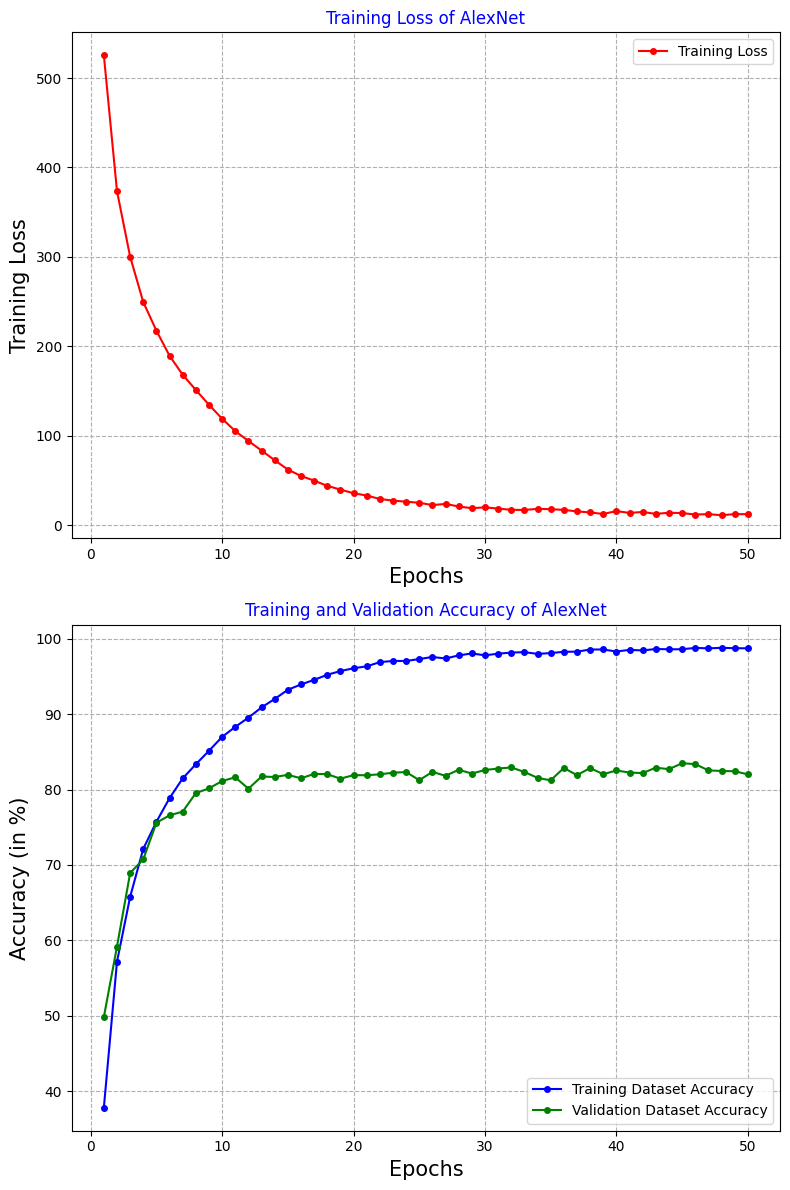

In [20]:
plot_training_curves(training_curves_list, model_name)

**Underfitting**

A statistical model or a machine learning algorithm is said to have underfitting when a model is too simple to capture data complexities. It represents the inability of the model to learn the training data effectively result in poor performance both on the training and testing data.

**Overfitting**

A statistical model is said to be overfitted when the model does not make accurate predictions on testing data. When a model gets trained with so much data, it starts learning from the noise and inaccurate data entries in our data set

# 3. Evaluating Model

Now, we will evaluate the model using test dataset and the metrics we use are accuracy and F1 score.

## 3.1.  Evaluating Trained Model

In [21]:
def evaluate_model(model, model_name, test_loader, device, label_map, num_classes=10):
    '''
    Function:- Evaluates the given model on test dataset
    
    Inputs:-
    model: Trained model
    test_loader: Dataloader of Test Data
    device: Device for testing the model
    label_map: Mapping of labels to class names
    model_name: Name of model
    num_classes: No. of classes
    
    Output:-
    Displays confusion matrix and prints classification report
    '''
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []
    space_sep_model_name = model_name.replace('_', ' ')

    # Gradient calculation is disabled
    with torch.no_grad():
        # Iterating through each batch of test dataloader
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            
            # Output is obtained
            z = model(x_test)
            
            # Predicted labels are collected
            _, predicted = torch.max(z.data, 1)
            
            # Current batch's labels and predictions are stored
            true_labels.extend(y_test.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
        
    # Accuracy is calculated
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    acc_test = (np.sum(true_labels == pred_labels) / len(true_labels)) * 100
    print(f"Final Accuracy on Test Set = {acc_test:.2f} %")

    # Confusion matrix is plotted
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix to get percentages

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Normalized Confusion Matrix of {space_sep_model_name}')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    class_names = [label_map[idx] for idx in range(num_classes)]
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm_normalized[i, j]*100, fmt),
                     horizontalalignment="center",
                     color="white" if cm_normalized[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f"Confusion_Matrix_for_{model_name.lower()}.jpg", dpi=500)
    plt.show()

    # Classification report is generated
    report = classification_report(true_labels, pred_labels, target_names = class_names)
    print('Classification Report:\n', report)

In [ ]:
# Newly trained model is evaluated
evaluate_model(model, 'New_AlexNet', test_loader, device, label_map)

## 3.2. Evaluating Complete Model

We will be loading the complete model trained for 60 epochs and compare it's performance with the model trained for 10 epochs.

In [22]:
filepath = '/kaggle/input/completely-trained-alexnet/pytorch/default/1/best_model_completely_trained_alexnet.pth'
loaded_model = load_stored_model('AlexNet', filepath, device) # Previously trained model is loaded
loaded_model

/tmp/ipykernel_36/3571532429.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


AlexNet(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=9216, out_features=4096, bias=True)
    (15): ReLU(inplace=True)
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=4096, ou

Final Accuracy on Test Set = 84.32 %


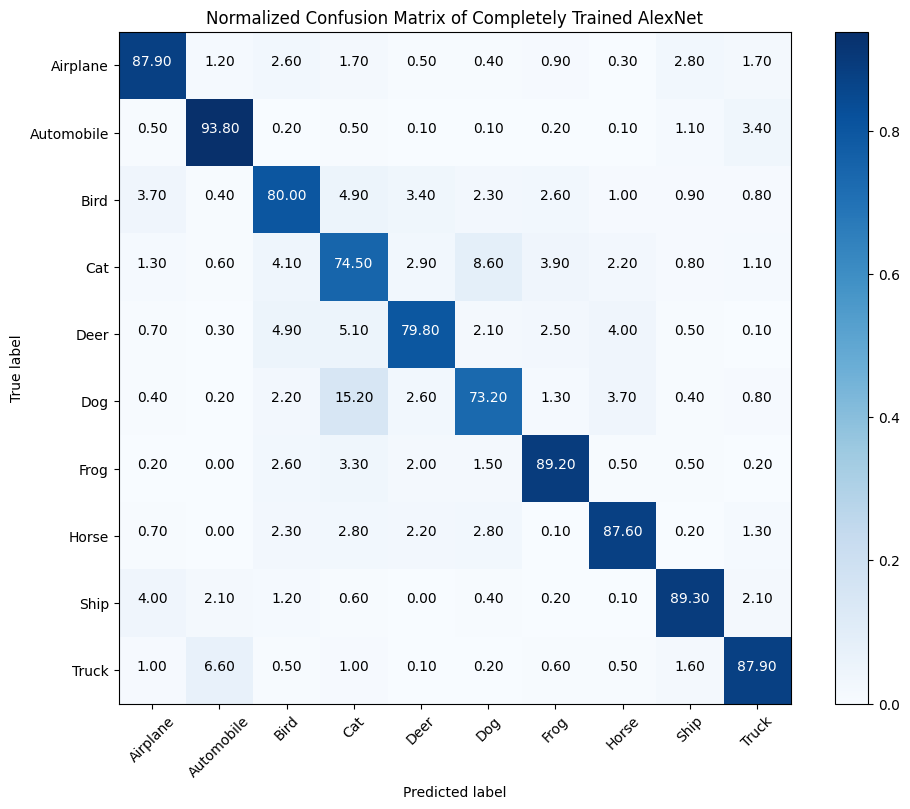

Classification Report:
               precision    recall  f1-score   support

    Airplane       0.88      0.88      0.88      1000
  Automobile       0.89      0.94      0.91      1000
        Bird       0.80      0.80      0.80      1000
         Cat       0.68      0.74      0.71      1000
        Deer       0.85      0.80      0.82      1000
         Dog       0.80      0.73      0.76      1000
        Frog       0.88      0.89      0.89      1000
       Horse       0.88      0.88      0.88      1000
        Ship       0.91      0.89      0.90      1000
       Truck       0.88      0.88      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [23]:
# Model is evaluated
evaluate_model(loaded_model, 'Completely_Trained_AlexNet', test_loader, device, label_map)

In [24]:
torch.cuda.empty_cache()